# Imports

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
!pip install transformers
from transformers import BertModel, BertConfig, BertTokenizer
from torch.utils.data import TensorDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 29.2 MB/s 
     |████████████████████████████████| 6.6 MB 15.2 MB/s 
     |████████████████████████████████| 596 kB 56.6 MB/s 
     |████████████████████████████████| 101 kB 14.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import io
from sklearn.model_selection import train_test_split
import torch 
import torch.nn.functional as F
from torch import flatten
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
import time
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import math
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Reading Data From Drive

In [ ]:
# Code to read file into Colaboratory:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1RvZn7S66cSj_tCQRUnJJCSt78SaAda9_/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('IMDB Dataset.csv')

# Adjusting the data format

## Reading data 

In [ ]:
dataframe = pd.read_csv('IMDB Dataset.csv')

In [ ]:
print(np.unique(np.array(dataframe.iloc[:, 1]), return_counts=True))

(array(['negative', 'positive'], dtype=object), array([25000, 25000]))


In [ ]:
print(dataframe)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


## Splitting data

In [ ]:
data, labels = dataframe.iloc[:, :-1], dataframe.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, stratify=labels)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=(2/3), stratify=y_test)

In [ ]:
print(np.unique(y_test, return_counts=True))
print(np.unique(y_validation, return_counts=True))
print(np.unique(y_train, return_counts=True))

(array(['negative', 'positive'], dtype=object), array([5000, 5000]))
(array(['negative', 'positive'], dtype=object), array([2500, 2500]))
(array(['negative', 'positive'], dtype=object), array([17500, 17500]))


In [ ]:
original_x_train = np.array(x_train).squeeze(1)
original_x_test = np.array(x_test).squeeze(1)
original_x_validation = np.array(x_validation).squeeze(1)

In [ ]:
pre_processed_x_train = np.array(x_train).squeeze(1)
pre_processed_x_test = np.array(x_test).squeeze(1)
pre_processed_x_validation = np.array(x_validation).squeeze(1)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_validation = np.array(y_validation)

## Pre processing function

In [ ]:
def pre_processing(data):
  for i in range (0,len(data)):
    
    #removing tags
    data[i] = BeautifulSoup((data[i])).get_text()
    
    #removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    temp = tokenizer.tokenize(data[i])
    data[i] = ' '.join([str(word) for word in temp])

    #Lowercase all characters
    data[i] = data[i].lower()

    #removing stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(data[i])
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    data[i] = ' '.join([str(word) for word in filtered_sentence])

    #removing numbers
    # data[i] = re.sub(r'\d+', '',  data[i])

    #Lemmatization of words
    wnl = WordNetLemmatizer()
    temp_list = nltk.word_tokenize(data[i])
    data[i] = ' '.join([wnl.lemmatize(words) for words in temp_list])
  return data

In [ ]:
pre_processed_x_train = pre_processing(pre_processed_x_train)
pre_processed_x_test = pre_processing(pre_processed_x_test)
pre_processed_x_validation = pre_processing(pre_processed_x_validation)

## Changing labels to numbers

In [ ]:
def change_labels(labels):
  for i in range (len(labels)):
    if labels[i] == 'positive':
      labels[i] = 1.0
    else:
      labels[i] = 0.0
  return labels.astype(float)

In [ ]:
y_test = change_labels(y_test)
y_train = change_labels(y_train)
y_validation = change_labels(y_validation)

##tokenize data

In [ ]:
def tokenized_data(dataset,tokenizer):
  input_ids = []
  token_type_ids = []
  attention_mask = [] 
  for sentence in dataset:
    bert_input = tokenizer(sentence,
                          padding='max_length', 
                          max_length = 512, 
                          truncation=True,
                          return_tensors="pt")
    input_ids.append(bert_input['input_ids'].squeeze(0))
    token_type_ids.append(bert_input['token_type_ids'].squeeze(0))
    attention_mask.append(bert_input['attention_mask'].squeeze(0))
  return input_ids,token_type_ids,attention_mask

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
original_input_ids_train,original_token_type_ids_train,original_attention_mask_train = tokenized_data(original_x_train, tokenizer)
original_input_ids_test,original_token_type_ids_test,original_attention_mask_test = tokenized_data(original_x_test, tokenizer)
original_input_ids_validation,original_token_type_ids_validation,original_attention_mask_validation = tokenized_data(original_x_validation, tokenizer)

In [ ]:
pre_processed_input_ids_train,pre_processed_token_type_ids_train,pre_processed_attention_mask_train = tokenized_data(pre_processed_x_train, tokenizer)
pre_processed_input_ids_test,pre_processed_token_type_ids_test,pre_processed_attention_mask_test = tokenized_data(pre_processed_x_test, tokenizer)
pre_processed_input_ids_validation,pre_processed_token_type_ids_validation,pre_processed_attention_mask_validation = tokenized_data(pre_processed_x_validation, tokenizer)

## Saving data to drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
np.save("/content/gdrive/MyDrive/IMDB/Labels/test.npy", y_test)
np.save("/content/gdrive/MyDrive/IMDB/Labels/train.npy", y_train)
np.save("/content/gdrive/MyDrive/IMDB/Labels/validation.npy", y_validation)

In [ ]:
np.save("/content/gdrive/MyDrive/IMDB/Original/input_ids_validation.npy", original_input_ids_validation)
np.save("/content/gdrive/MyDrive/IMDB/Original/attention_mask_validation.npy", original_attention_mask_validation)

np.save("/content/gdrive/MyDrive/IMDB/Original/input_ids_train.npy", original_input_ids_train)
np.save("/content/gdrive/MyDrive/IMDB/Original/attention_mask_train.npy", original_attention_mask_train)

np.save("/content/gdrive/MyDrive/IMDB/Original/input_ids_test.npy", original_input_ids_test)
np.save("/content/gdrive/MyDrive/IMDB/Original/attention_mask_test.npy", original_attention_mask_test)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
np.save("/content/gdrive/MyDrive/IMDB/PreProcessed/input_ids_validation.npy", pre_processed_input_ids_validation)
np.save("/content/gdrive/MyDrive/IMDB/PreProcessed/attention_mask_validation.npy", pre_processed_attention_mask_validation)

np.save("/content/gdrive/MyDrive/IMDB/PreProcessed/input_ids_train.npy", pre_processed_input_ids_train)
np.save("/content/gdrive/MyDrive/IMDB/PreProcessed/attention_mask_train.npy", pre_processed_attention_mask_train)

np.save("/content/gdrive/MyDrive/IMDB/PreProcessed/input_ids_test.npy", pre_processed_input_ids_test)
np.save("/content/gdrive/MyDrive/IMDB/PreProcessed/attention_mask_test.npy", pre_processed_attention_mask_test)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Loading data from drive

### Original data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
original_input_ids_train = np.load("/content/gdrive/MyDrive/IMDB/Original/input_ids_train.npy",allow_pickle=True)
original_attention_mask_train = np.load("/content/gdrive/MyDrive/IMDB/Original/attention_mask_train.npy",allow_pickle=True)
y_train = np.load("/content/gdrive/MyDrive/IMDB/Labels/train.npy", allow_pickle=True)
original_input_ids_train = original_input_ids_train.tolist()
original_attention_mask_train = original_attention_mask_train.tolist()

In [ ]:
original_input_ids_validation = np.load("/content/gdrive/MyDrive/IMDB/Original/input_ids_validation.npy",allow_pickle=True)
original_attention_mask_validation = np.load("/content/gdrive/MyDrive/IMDB/Original/attention_mask_validation.npy",allow_pickle=True)
y_validation = np.load("/content/gdrive/MyDrive/IMDB/Labels/validation.npy", allow_pickle=True)
original_input_ids_validation = original_input_ids_validation.tolist()
original_attention_mask_validation = original_attention_mask_validation.tolist()

In [ ]:
original_input_ids_test = np.load("/content/gdrive/MyDrive/IMDB/Original/input_ids_test.npy",allow_pickle=True)
original_attention_mask_test = np.load("/content/gdrive/MyDrive/IMDB/Original/attention_mask_test.npy",allow_pickle=True)
y_test = np.load("/content/gdrive/MyDrive/IMDB/Labels/test.npy", allow_pickle=True)
original_input_ids_test = original_input_ids_test.tolist()
original_attention_mask_test = original_attention_mask_test.tolist()

### PreProcessed data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pre_processed_input_ids_train = np.load("/content/gdrive/MyDrive/IMDB/PreProcessed/input_ids_train.npy",allow_pickle=True)
pre_processed_attention_mask_train = np.load("/content/gdrive/MyDrive/IMDB/PreProcessed/attention_mask_train.npy",allow_pickle=True)
y_train = np.load("/content/gdrive/MyDrive/IMDB/Labels/train.npy", allow_pickle=True)
pre_processed_input_ids_train = pre_processed_input_ids_train.tolist()
pre_processed_attention_mask_train = pre_processed_attention_mask_train.tolist()

In [ ]:
pre_processed_input_ids_validation = np.load("/content/gdrive/MyDrive/IMDB/PreProcessed/input_ids_validation.npy",allow_pickle=True)
pre_processed_attention_mask_validation = np.load("/content/gdrive/MyDrive/IMDB/PreProcessed/attention_mask_validation.npy",allow_pickle=True)
y_validation = np.load("/content/gdrive/MyDrive/IMDB/Labels/validation.npy", allow_pickle=True)
pre_processed_input_ids_validation = pre_processed_input_ids_validation.tolist()
pre_processed_attention_mask_validation = pre_processed_attention_mask_validation.tolist()

In [ ]:
pre_processed_input_ids_test = np.load("/content/gdrive/MyDrive/IMDB/PreProcessed/input_ids_test.npy",allow_pickle=True)
pre_processed_attention_mask_test = np.load("/content/gdrive/MyDrive/IMDB/PreProcessed/attention_mask_test.npy",allow_pickle=True)
y_test = np.load("/content/gdrive/MyDrive/IMDB/Labels/test.npy", allow_pickle=True)
pre_processed_input_ids_test = pre_processed_input_ids_test.tolist()
pre_processed_attention_mask_test = pre_processed_attention_mask_test.tolist()

#Classification

###Dataset Class

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, inputIDs, attentionMasks, labels):
        self.labels = labels
        self.attentionMasks = attentionMasks
        self.inputIDs = inputIDs

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return torch.tensor(self.inputIDs[index]), torch.tensor(self.attentionMasks[index]), torch.tensor(self.labels[index])

### Model

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    
    self.fc1 = nn.Linear(in_features=768, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=128)
    self.fc4 = nn.Linear(in_features=128, out_features=64)
    self.fc5 = nn.Linear(in_features=64, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.dropout(x, 0.4)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))

    return F.sigmoid(self.fc5(x))

### Method

In [ ]:
def tvt(optimizer, mode, model, dataloader):
  if mode == 'train':
    model.train()
    numberOfBatches = trainNumOfBatches
  elif mode == 'validation':
    model.eval()
    numberOfBatches = valNumOfBatches
  else:
    model.eval()
    predictedLabels = []
  batchNumber = 1
  totalLoss = 0
  correctPred = 0
  counter = 0
  lossFn = nn.BCELoss()
  for (input_ids, input_mask, labels) in dataloader:

        (input_ids, input_mask, labels) = (input_ids.to(device), input_mask.to(device), labels.to(device))

        pred = model(input_ids, input_mask)

        if mode != 'test':
          pred = pred.squeeze(1)
          pred.cpu()
          temp = pred.cpu().detach().numpy().copy()

          for i in range(len(pred)):
            temp[i] = 0. if temp[i] <= 0.5 else 1.
          loss = lossFn(pred, labels.float())
          totalLoss += loss
          compare = [1 if i==j else 0 for i, j in zip(temp,labels)]
          correctPred += np.array(compare).sum()
        if mode == 'train':
          optimizer.zero_grad() 
          loss.backward()  
          optimizer.step()
        if mode == 'test':
          temp = pred.cpu().detach().numpy().copy()
          for i in range(len(pred)):
            temp[i] = 0. if temp[i] <= 0.5 else 1.
          predictedLabels.extend(temp)
          correctPred = predictedLabels
        
        del input_ids
        del input_mask
        del labels
        torch.cuda.empty_cache()
        batchNumber += 1

  return totalLoss/len(dataloader), correctPred

### Parameters

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
INIT_LR = 1e-2
BATCH_SIZE = 16
EPOCHS = 5

### PreProcessed data dataloader

In [ ]:
pre_processed_train_data = IMDBDataset(pre_processed_input_ids_train,pre_processed_attention_mask_train,y_train)
pre_processed_test_data = IMDBDataset(pre_processed_input_ids_test,pre_processed_attention_mask_test,y_test)
pre_processed_validation_data = IMDBDataset(pre_processed_input_ids_validation,pre_processed_attention_mask_validation,y_validation)

In [ ]:
trainDataLoader = DataLoader(pre_processed_train_data, shuffle=True, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(pre_processed_test_data, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(pre_processed_validation_data, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

### Optimizer setup

In [ ]:
model = ModifiedBERT()
model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.1, threshold=1e-4, verbose=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Running model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


you must provide the path you want to save the model in it each epoch


In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-2)/model.pt'  
trainLoss = [100.0]
validationLoss = [100.0]
trainAcc = [0.0]
validationAcc = [0.0]

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, testDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(testDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(testDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-2)/trainLoss", trainLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-2)/trainAcc", trainAcc)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-2)/validationLoss", validationLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-2)/validationAcc", validationAcc)
  torch.save(model.state_dict(), PATH)

###Increasing epochs on already trained model

loading data from drive to be able to plot all the results

In [ ]:
trainLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/trainLoss.npy",allow_pickle=True)
trainAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/trainAcc.npy",allow_pickle=True)
trainLoss = trainLoss.tolist()
trainAcc = trainAcc.tolist()

validationLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/validationLoss.npy",allow_pickle=True)
validationAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/validationAcc.npy",allow_pickle=True)
validationLoss = validationLoss.tolist()
validationAcc = validationAcc.tolist()

In [ ]:
EPOCHS = 1
PATH = '/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/model.pt'  

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  # scheduler.step(avgValLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/trainLoss", trainLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/trainAcc", trainAcc)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/validationLoss", validationLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/validationAcc", validationAcc)
  torch.save(model.state_dict(), PATH)

# Plotting Function

## loss & accuracy

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def Plotting(trainLoss,trainAcc, validationLoss, validationAcc):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig2 = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(go.Scatter(y=validationLoss, name="Validation Loss"), secondary_y=False)
    fig.add_trace(go.Scatter(y=trainLoss, name="Training Loss"), secondary_y=False)
    fig2.add_trace(go.Scatter(y=validationAcc, name="Validation Accuracy"), secondary_y=False)
    fig2.add_trace(go.Scatter(y=trainAcc, name="Train Accuracy"), secondary_y=False)

    # Add figure title
    fig.update_layout(title_text="Loss of Model")
    fig2.update_layout(title_text="Accuracy of Model")

    # Set x-axis title
    fig.update_xaxes(title_text="Epoch")
    fig.update_yaxes(title_text="Loss")
    fig2.update_xaxes(title_text="Epoch")
    fig2.update_yaxes(title_text="Accuracy")
    fig.show()
    fig2.show()
    return

## learning rates

In [ ]:
import matplotlib.pyplot as plt
def plotting_learning_rates(list1,list2,list3,list4,list5,lr1,lr2,lr3,lr4,lr5):
  plt.figure(figsize=(12, 6))
  plt.plot(list1, color='red')
  plt.plot(list2, color='blue')
  plt.plot(list3, color='green')
  plt.plot(list4, color='black')
  plt.plot(list5, color='yellow')
  plt.legend([lr1, lr2,lr3,lr4,lr5], loc ="lower right")
  plt.title('Validation Accuracy For Different Learning Rates')
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')

# Plotting and Classification Report

## Preprocessed

###Learning rate (10^-6)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/model.pt'  
model.load_state_dict(torch.load(PATH, map_location= torch.device('cuda')))

<All keys matched successfully>

In [ ]:
trainLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/trainLoss.npy",allow_pickle=True)
trainAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/trainAcc.npy",allow_pickle=True)
trainLoss = trainLoss.tolist()
trainAcc = trainAcc.tolist()

validationLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/validationLoss.npy",allow_pickle=True)
validationAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/validationAcc.npy",allow_pickle=True)
validationLoss = validationLoss.tolist()
validationAcc = validationAcc.tolist()

In [ ]:
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)


Testing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      5000
         1.0       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



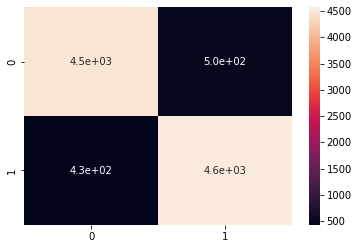

In [ ]:
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(pre_processed_test_data.labels), np.array(predections))
  print(classification_report(np.array(pre_processed_test_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

###Learning rate (10^-4)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-4)/model.pt'  
model.load_state_dict(torch.load(PATH, map_location= torch.device('cuda')))

<All keys matched successfully>

In [ ]:
trainLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-4)/trainLoss.npy",allow_pickle=True)
trainAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-4)/trainAcc.npy",allow_pickle=True)
trainLoss = trainLoss.tolist()
trainAcc = trainAcc.tolist()

validationLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-4)/validationLoss.npy",allow_pickle=True)
validationAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-4)/validationAcc.npy",allow_pickle=True)
validationLoss = validationLoss.tolist()
validationAcc = validationAcc.tolist()

In [ ]:
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)


Testing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



              precision    recall  f1-score   support

         0.0       0.50      0.97      0.66      5000
         1.0       0.48      0.03      0.06      5000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.36     10000
weighted avg       0.49      0.50      0.36     10000



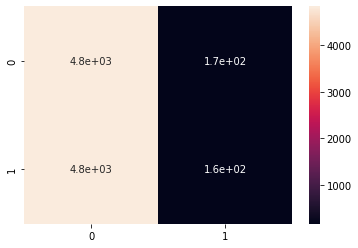

In [ ]:
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(pre_processed_test_data.labels), np.array(predections))
  print(classification_report(np.array(pre_processed_test_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

###Learning rate (10^-8) (only 3 epochs)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-8)/model.pt'  
model.load_state_dict(torch.load(PATH, map_location= torch.device('cuda')))

<All keys matched successfully>

In [ ]:
trainLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-8)/trainLoss.npy",allow_pickle=True)
trainAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-8)/trainAcc.npy",allow_pickle=True)
trainLoss = trainLoss.tolist()
trainAcc = trainAcc.tolist()

validationLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-8)/validationLoss.npy",allow_pickle=True)
validationAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-8)/validationAcc.npy",allow_pickle=True)
validationLoss = validationLoss.tolist()
validationAcc = validationAcc.tolist()

In [ ]:
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)


Testing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5000
         1.0       0.50      1.00      0.67      5000

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



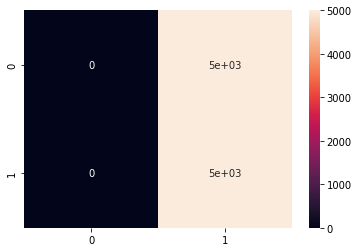

In [ ]:
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(pre_processed_test_data.labels), np.array(predections))
  print(classification_report(np.array(pre_processed_test_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

###Learning rate (10^-2)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-2)/model.pt'  
model.load_state_dict(torch.load(PATH, map_location= torch.device('cuda')))

<All keys matched successfully>

In [ ]:
trainLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-2)/trainLoss.npy",allow_pickle=True)
trainAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-2)/trainAcc.npy",allow_pickle=True)
trainLoss = trainLoss.tolist()
trainAcc = trainAcc.tolist()

validationLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-2)/validationLoss.npy",allow_pickle=True)
validationAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-2)/validationAcc.npy",allow_pickle=True)
validationLoss = validationLoss.tolist()
validationAcc = validationAcc.tolist()

In [ ]:
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)


Testing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5000
         1.0       0.50      1.00      0.67      5000

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



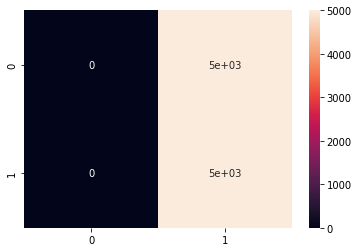

In [ ]:
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(pre_processed_test_data.labels), np.array(predections))
  print(classification_report(np.array(pre_processed_test_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

###Learning rate (10^-5) 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-5)/model.pt'  
model.load_state_dict(torch.load(PATH, map_location= torch.device('cuda')))

<All keys matched successfully>

In [ ]:
trainLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-5)/trainLoss.npy",allow_pickle=True)
trainAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-5)/trainAcc.npy",allow_pickle=True)
trainLoss = trainLoss.tolist()
trainAcc = trainAcc.tolist()

validationLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-5)/validationLoss.npy",allow_pickle=True)
validationAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-5)/validationAcc.npy",allow_pickle=True)
validationLoss = validationLoss.tolist()
validationAcc = validationAcc.tolist()

In [ ]:
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)


Testing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      5000
         1.0       0.94      0.88      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



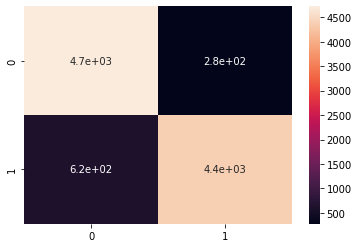

In [ ]:
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(pre_processed_test_data.labels), np.array(predections))
  print(classification_report(np.array(pre_processed_test_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

###Learning rate (10^-5) (with 2 dropouts)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-5)/model.pt'  
model.load_state_dict(torch.load(PATH, map_location= torch.device('cuda')))

<All keys matched successfully>

In [ ]:
trainLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-5)/trainLoss.npy",allow_pickle=True)
trainAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-5)/trainAcc.npy",allow_pickle=True)
trainLoss = trainLoss.tolist()
trainAcc = trainAcc.tolist()

validationLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-5)/validationLoss.npy",allow_pickle=True)
validationAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-5)/validationAcc.npy",allow_pickle=True)
validationLoss = validationLoss.tolist()
validationAcc = validationAcc.tolist()

In [ ]:
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)


Testing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      5000
         1.0       0.89      0.93      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



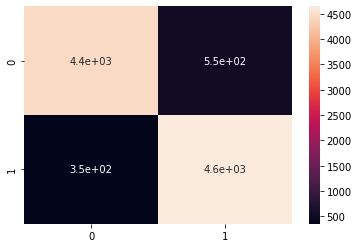

In [ ]:
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(pre_processed_test_data.labels), np.array(predections))
  print(classification_report(np.array(pre_processed_test_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

###Learning rate (10^-5) (with 3 dropouts)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/PreProcessed2 (-5)/model.pt'  
model.load_state_dict(torch.load(PATH, map_location= torch.device('cuda')))

<All keys matched successfully>

In [ ]:
trainLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed2 (-5)/trainLoss.npy",allow_pickle=True)
trainAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed2 (-5)/trainAcc.npy",allow_pickle=True)
trainLoss = trainLoss.tolist()
trainAcc = trainAcc.tolist()

validationLoss = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed2 (-5)/validationLoss.npy",allow_pickle=True)
validationAcc = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed2 (-5)/validationAcc.npy",allow_pickle=True)
validationLoss = validationLoss.tolist()
validationAcc = validationAcc.tolist()

In [ ]:
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)


Testing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      5000
         1.0       0.91      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



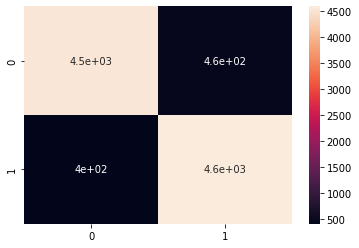

In [ ]:
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(pre_processed_test_data.labels), np.array(predections))
  print(classification_report(np.array(pre_processed_test_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

##Learning Rates

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
validationAcc6 = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-6)/validationAcc.npy",allow_pickle=True)
validationAcc5 = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-5)/validationAcc.npy",allow_pickle=True)
validationAcc4 = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-4)/validationAcc.npy",allow_pickle=True)
validationAcc8 = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-8)/validationAcc.npy",allow_pickle=True)
validationAcc2 = np.load("/content/gdrive/MyDrive/IMDB/Models/PreProcessed (-2)/validationAcc.npy",allow_pickle=True)

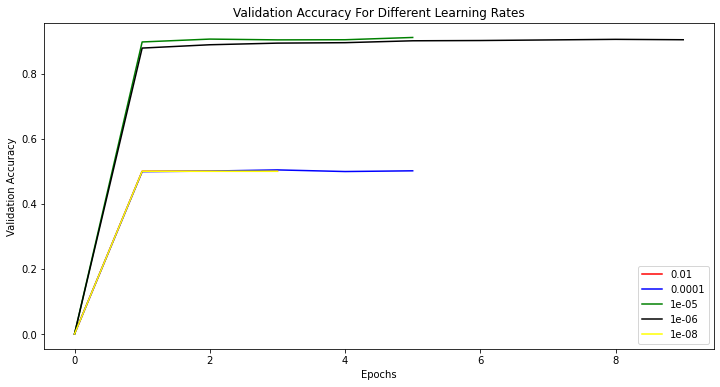

In [ ]:
plotting_learning_rates(validationAcc2,validationAcc4,validationAcc5,validationAcc6,validationAcc8,1e-2,1e-4,1e-5,1e-6,1e-8)

# Layers Tunning Different Models

## Different models all on learning rate 10^-2 and 10^-4 

all the models get validation and train accuracy 50% without any increase with epochs

###Model 1

1024 -> 512 -> 256 -> 128 -> 64 -> 1

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()

    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False)
    self.fc1 = nn.Linear(in_features=768, out_features=1024)
    self.fc6 = nn.Linear(in_features=1024, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=128)
    self.fc4 = nn.Linear(in_features=128, out_features=64)
    self.fc5 = nn.Linear(in_features=64, out_features=1)
    

 def forward(self, input_ids,input_masks):
    
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc6(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return torch.sigmoid(self.fc5(x))

###Model 2

512 -> 256 -> 256 -> 128 -> 64 -> 1

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    
    self.fc1 = nn.Linear(in_features=768, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc6 = nn.Linear(in_features=256, out_features=256 )
    self.fc3 = nn.Linear(in_features=256, out_features=128)
    self.fc4 = nn.Linear(in_features=128, out_features=64)
    self.fc5 = nn.Linear(in_features=64, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc6(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))

    return F.sigmoid(self.fc5(x))

###Model 3

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    
    self.fc1 = nn.Linear(in_features=768, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=128)
    self.fc6 = nn.Linear(in_features=128, out_features=256)
    self.fc7 = nn.Linear(in_features=256, out_features=128)
    self.fc4 = nn.Linear(in_features=128, out_features=64)
    self.fc5 = nn.Linear(in_features=64, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc6(x))
    x = F.relu(self.fc7(x))
    x = F.relu(self.fc4(x))

    return F.sigmoid(self.fc5(x))

### output of the 3 models was similar to this

In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-2)/model.pt'  
trainLoss = [100.0]
validationLoss = [100.0]
trainAcc = [0.0]
validationAcc = [0.0]

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, testDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(testDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(testDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-2)/trainLoss", trainLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-2)/trainAcc", trainAcc)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-2)/validationLoss", validationLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Models/PreProcessed1 (-2)/validationAcc", validationAcc)
  torch.save(model.state_dict(), PATH)

Training Model
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Train loss: 0.695497, Train accuracy: 0.4958
Validation loss: 0.693176, Validation accuracy: 0.5000
Epoch 2/5
Train loss: 0.693578, Train accuracy: 0.4968
Validation loss: 0.693176, Validation accuracy: 0.5000
Epoch 00002: reducing learning rate of group 0 to 1.0000e-03.
Epoch 3/5


KeyboardInterrupt: ignored

## Models on learning rates 10^-5 & 10^-6 

### Model 1 (50%)

10 linear layers 512 -> 256 ->.... -> 4 -> 2 -> 1
Increase complexity of the model

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    
    self.fc1 = nn.Linear(in_features=768, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=128)
    self.fc4 = nn.Linear(in_features=128, out_features=64)
    self.fc5 = nn.Linear(in_features=64, out_features=32)
    self.fc6 = nn.Linear(in_features=32, out_features=16)
    self.fc7 = nn.Linear(in_features=16, out_features=8)
    self.fc8 = nn.Linear(in_features=8, out_features=4)
    self.fc9 = nn.Linear(in_features=4, out_features=2)
    self.fc10 = nn.Linear(in_features=2, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = F.relu(self.fc7(x))
    x = F.relu(self.fc8(x))
    x = F.relu(self.fc9(x))
    return F.sigmoid(self.fc10(x))

learning rate -6

In [ ]:
INIT_LR = 1e-6
BATCH_SIZE = 16
EPOCHS = 10

model = ModifiedBERT()
model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.1, threshold=1e-4, verbose=True)

trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone(

Training Model
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.703545, Train accuracy: 0.5098
Epoch 2/10
Train loss: 0.703538, Train accuracy: 0.5098
Epoch 3/10
Train loss: 0.703531, Train accuracy: 0.5098
Epoch 4/10
Train loss: 0.703524, Train accuracy: 0.5098
Epoch 5/10
Train loss: 0.703517, Train accuracy: 0.5098
Epoch 6/10
Train loss: 0.703509, Train accuracy: 0.5098
Epoch 7/10
Train loss: 0.703502, Train accuracy: 0.5098
Epoch 8/10
Train loss: 0.703492, Train accuracy: 0.5098
Epoch 9/10
Train loss: 0.703480, Train accuracy: 0.5098
Epoch 10/10
Train loss: 0.703467, Train accuracy: 0.5098


### Model 2 (batch normalization)

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    self.batchnorm2 = nn.BatchNorm1d(256)
    self.fc1 = nn.Linear(in_features=768, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=64)
    self.fc4 = nn.Linear(in_features=64, out_features=8)
    self.fc5 = nn.Linear(in_features=8, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.batchnorm2(x)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return F.sigmoid(self.fc5(x))

Learning Rate -4

In [ ]:
INIT_LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 10

model = ModifiedBERT()
model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.1, threshold=1e-4, verbose=True)

trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []
# PATH = '/content/gdrive/MyDrive/IMDB/Models/FirstModel_6LR_5Epochs.pt'

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone(

Training Model
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.707483, Train accuracy: 0.4902
Epoch 2/10
Train loss: 0.705609, Train accuracy: 0.4902
Epoch 3/10
Train loss: 0.702054, Train accuracy: 0.4912
Epoch 4/10
Train loss: 0.702211, Train accuracy: 0.4912
Epoch 5/10
Train loss: 0.700784, Train accuracy: 0.4873
Epoch 6/10
Train loss: 0.699585, Train accuracy: 0.4873
Epoch 7/10
Train loss: 0.700934, Train accuracy: 0.4902
Epoch 8/10
Train loss: 0.697919, Train accuracy: 0.4795
Epoch 9/10
Train loss: 0.693394, Train accuracy: 0.5195
Epoch 10/10
Train loss: 0.696501, Train accuracy: 0.4980


#Model 3

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.fc1 = nn.Linear(in_features=768, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=8)
    self.fc4 = nn.Linear(in_features=8, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.batchnorm2(x)
    x = F.relu(self.fc3(x))
    return F.sigmoid(self.fc4(x))

In [ ]:
trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

Plotting(trainLoss,trainAcc, validationLoss, validationAcc)

Training Model
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.704327, Train accuracy: 0.5000
Validation loss: 0.675010, Validation accuracy: 0.5050
Epoch 2/5
Train loss: 0.655347, Train accuracy: 0.5235
Validation loss: 0.611424, Validation accuracy: 0.6170
Epoch 3/5
Train loss: 0.594298, Train accuracy: 0.6605
Validation loss: 0.550161, Validation accuracy: 0.8100
Epoch 4/5
Train loss: 0.551839, Train accuracy: 0.7548
Validation loss: 0.524864, Validation accuracy: 0.8360
Epoch 5/5
Train loss: 0.530275, Train accuracy: 0.7855
Validation loss: 0.505660, Validation accuracy: 0.8450
